In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime

from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%load_ext autoreload
%autoreload 2

import plotly.io as pio
pio.renderers.default = 'iframe'

/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_72616/1556374353.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## Local Utils File
from utils.eda import *
from utils.utils import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *
from utils.models import Regression
from utils.regression_evaluation import RegressionEvaluate

In [3]:
train_df = pd.read_csv(r"./dataset/train.csv")
test_df = pd.read_csv(r"./dataset/test.csv")


In [4]:
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         10000 non-null  int64  
 1   title              10000 non-null  object 
 2   make               9459 non-null   object 
 3   model              10000 non-null  object 
 4   description        9732 non-null   object 
 5   manufactured       9997 non-null   float64
 6   original_reg_date  97 non-null     object 
 7   reg_date           10000 non-null  object 
 8   type_of_vehicle    10000 non-null  object 
 9   category           10000 non-null  object 
 10  transmission       10000 non-null  object 
 11  curb_weight        9890 non-null   float64
 12  power              8914 non-null   float64
 13  fuel_type          2350 non-null   object 
 14  engine_cap         9765 non-null   float64
 15  no_of_owners       9992 non-null   float64
 16  depreciation       9799

None

In [5]:
## Create Feature Set Function
def fill_column_b_with_mean(df, column_a, column_b):
    # Calculate the mean of column B grouped by column A
    values = df.groupby(column_a)[column_b].agg(["mean"]).rename(
        columns={"mean": column_b})[column_b]
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # If column B is NaN, fill it with the mean value of column B for the corresponding value in column A
        if pd.isna(row[column_b]):
            df.at[index, column_b] = values[row[column_a]]
    return df

def make_features(df:pd.DataFrame):
    # before data cleaning
    nan_overview_before = df.isnull().sum()

    # clean model
    df['model'] = df['model'].apply(lambda x:x.replace('(', ''))
    df['reg_date_dt'] = df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
    df['reg_date_year'] = df['reg_date_dt'].apply(lambda x:x.year)
    df['reg_date_month'] = df['reg_date_dt'].apply(lambda x:x.month)

    # Adding additional feature for imputation later
    df["model_make"] = df.model + "_" + df.make

    # Make data Imputation
    make_ls = df['make'].dropna().unique()
    compiled_regex = compile_make_pattern(make_ls)

    df = apply_make_extraction(df, compiled_regex)
    df['make'] = df['make'].fillna(df['extracted_make'])

    # Type of vehicle encoding
    df = generic_one_hotencoding(df, "type_of_vehicle")
    df = fill_column_b_with_mean(df,"model_make","curb_weight")
    df = fill_column_b_with_mean(df,"model_make","power")
    # df = inpute_by_ref_col(df,ref="model_make",feature="curb_weight",method="mean")
    # df = inpute_by_ref_col(df,ref="model_make",feature="power",method="mean")
    df = impute_owner_number(df)

    # Manufactured

    df['effective_reg_date'] = df['original_reg_date'].fillna(df['reg_date'])
    df = df.drop(columns=['original_reg_date'])
    df['effective_reg_date'] = pd.to_datetime(df['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
    df['manufactured'] = df['manufactured'].fillna(df['effective_reg_date'].dt.year)

    # Vehicle age calculation
    df = calc_vehicle_age(df)

    # Depreciation imputation
    avg_depreciation_rate_wo_age = calculate_depreciation_rate_without_age(df)
    avg_depreciation_rate_with_age = calculate_depreciation_rate_with_age(df)
    df = impute_depreciation(df, avg_depreciation_rate_wo_age, avg_depreciation_rate_with_age)

    df = impute_mileage(df)

    # Getting OMV data
    result_ls = get_lta_omv_data(2002, 2025)
    df_lta_car_data = preprocess_lta_omv_data(result_ls)

    df['omv_new'] = df['omv']
    df['omv_new'] = df.apply(lambda row: impute_using_lta_data(row,df_lta_car_data), axis=1)
    df['omv_new'] = df['omv_new'].fillna(df['omv_new'].mean())

    df = impute_lifespan(df)

    # Get fuel type
    df = get_fuel_type(df)

    # Get features
    df['cylinder_cnt'] = df['features'].apply(lambda x: extract_cylinder_from_features(x) if pd.notnull(x) else None)
    cylinder_count_dict = extract_cylinder_by_model_make(df)
    df['cylinder_cnt'] = df.apply(lambda x:impute_row_by_make_model(x, cylinder_count_dict, 'cylinder_cnt'), axis=1)
    # fill remaining values with median of 4 cylinder (most common engine)
    median_cylinder_cnt = df['cylinder_cnt'].median(axis=0)
    df['cylinder_cnt'] = df['cylinder_cnt'].fillna(median_cylinder_cnt)

    # after data cleaning
    nan_overview_after = df.isnull().sum()

    # Combine the series into a DataFrame
    nan_overview_results = pd.concat([nan_overview_before, nan_overview_after], axis=1)
    display(nan_overview_results)
    
    return df, nan_overview_results



In [8]:
transformed_df , nan_results = make_features(train_df)

len of lifespan na: 22671
Original Imputation Nan 19121
After Imputation Nan 17956


,0,1
listing_id,0.0,0.0
title,0.0,0.0
make,0.0,0.0
model,0.0,0.0
description,680.0,680.0
manufactured,7.0,0.0
original_reg_date,24745.0,NaN
reg_date,0.0,0.0
type_of_vehicle,0.0,0.0
category,0.0,0.0


In [9]:
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv_new',
       'engine_cap', 'depreciation', 'mileage', 'dereg_value','no_of_owners','coe','type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van','car_age']

X_train, X_test, y_train, y_test = train_test_split(transformed_df[features], transformed_df['price'], test_size=0.3, random_state=42)


In [10]:
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[features])

# Split data into training and test sets
X_train[features] = imputer.transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

# Fit and transform the numerical columns
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [ ]:
# 2. Initialize the Regression class
regressor = Regression()

# 3. Define parameters for hyperparameter tuning
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Example for Random Forest with accuracy scoring and KFold validation
tuner, best_params, tuner_results = regressor.hyperparameter_tuning(
    df_tuple=(X_train, y_train),   # The training data (X, y)
    score_metric='neg_root_mean_squared_error',       # Scoring metric
    kfold_type='kfold',            # Type of fold (KFold used here)
    n_splits=2,                    # Number of splits for KFold
    params=params,                 # Hyperparameter grid to search
    model_name='random_forest'      # Model to use (Random Forest in this case)
)

# 4. View the best hyperparameters and fit the model
print(f"Best Parameters: {best_params}")

# 5. Use the best model to predict on the test set
best_model = tuner.best_estimator_


In [ ]:
import joblib

# Save model 
model_name = "random_forest_v1"
save_path = f"./model_assets"
# Save the trained model
joblib.dump(best_model, f"{save_path}/{model_name}.joblib")

INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



{'Train RMSE ::': '9389.4', 'Train MAE': '2405.5', 'Train PMAE': '2.1280', 'Train PME ': '-0.601', 'Train R2': '0.996', 'Train Adj R2': '0.9964372360999576', 'Train Predicted R2': '0.9963382496871186'} {'Valid RMSE ::': '27468.', 'Valid MAE': '6536.5', 'Valid PMAE': '6.0360', 'Valid PME ': '-1.835', 'Valid R2': '0.966', 'Valid Adj R2': '0.9668970421897676', 'Valid Predicted R2': '0.9657315136268408'}


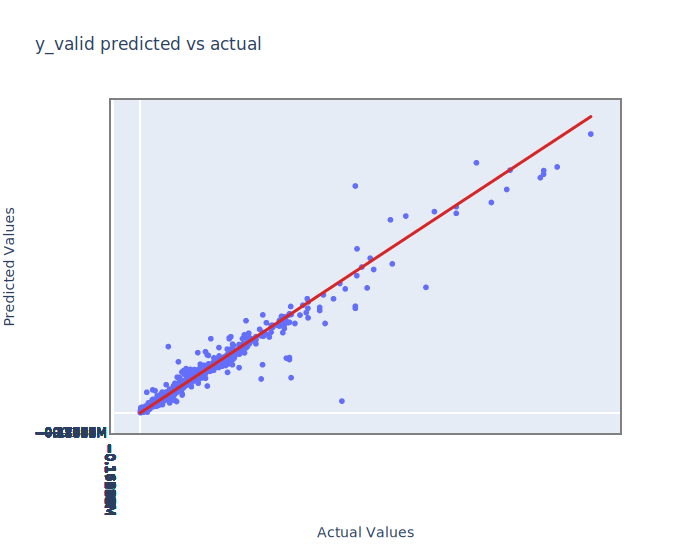

KeyboardInterrupt: 

In [11]:
model_name = "random_forest_v1"
save_path = f"./model_assets"
eval_util = RegressionEvaluate(save_path)
eval_util.regression_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_test,y_test),model_name=model_name)


In [30]:
import joblib
import plotly.express as px
import plotly.graph_objects as go

def _infer_type(data) -> np.ndarray:

    ## type checker

    try:
        assert type(data) == np.ndarray, "incorrect type"

    except AssertionError:
        data = data.to_numpy()
        print("INFO [_infer_type] :: Type changed")
        return data

    else:
        return data

def mini_reg_evaluate(
    df_train_tuple: tuple, df_valid_tuple: tuple, model_name: str, save_path:str
):

    model = joblib.load(f"{save_path}/{model_name}.joblib")
    X_train, y_train = df_train_tuple[0], df_train_tuple[1]
    X_valid, y_valid = df_valid_tuple[0], df_valid_tuple[1]

    ## type checker

    X_train = _infer_type(X_train)
    y_train = _infer_type(y_train)
    X_valid = _infer_type(X_valid)
    y_valid = _infer_type(y_valid)

    # Train and validation scores
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    # Visualize scatter plot for validation data
    plt.scatter(y_valid, y_valid_pred, color='blue', alpha=0.5)
    plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color='red', linestyle='--')
    plt.title("y_valid predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize scatter plot for training data
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
    plt.title("y_train predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize residual plot
    plt.scatter(y_valid_pred, y_valid_pred - y_valid, color='blue', alpha=0.5)
    plt.plot([y_valid_pred.min(), y_valid_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Validation Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', alpha=0.5)
    plt.plot([y_train_pred.min(), y_train_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Training Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
  

INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



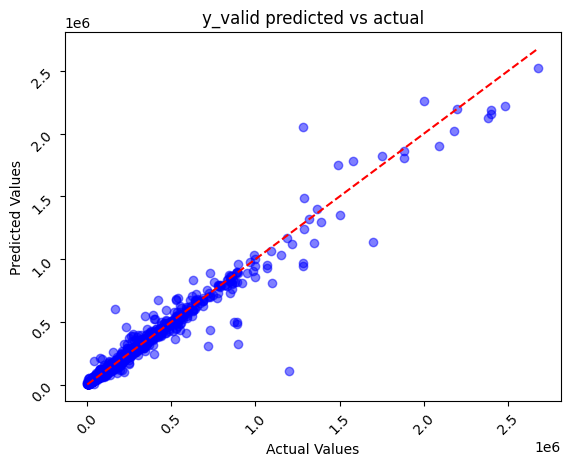

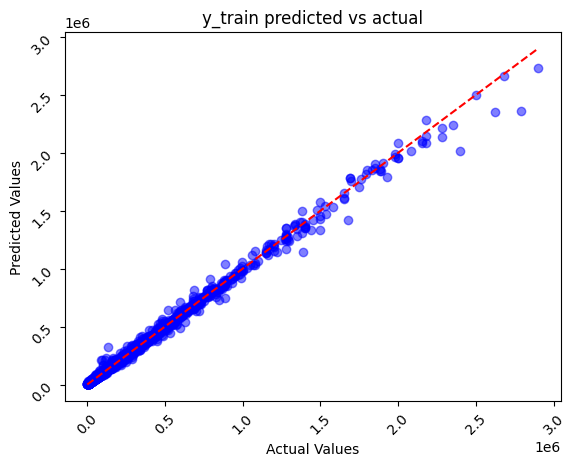

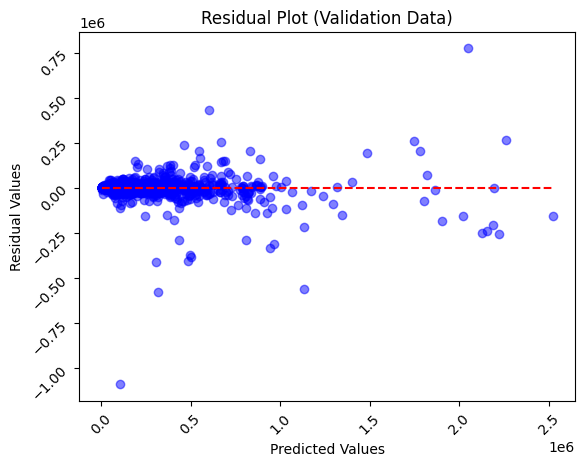

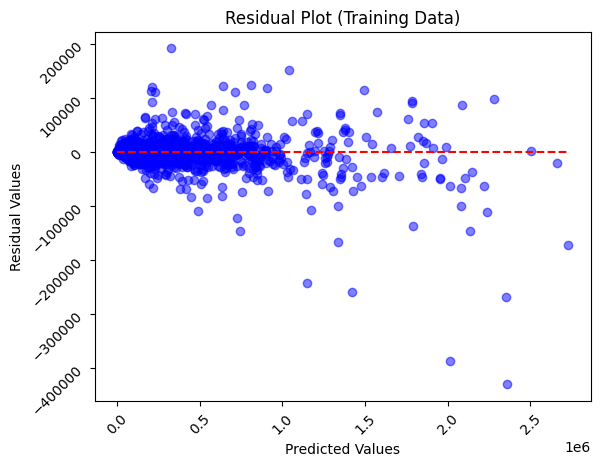

In [31]:
model_name = "random_forest_v1"
save_path = f"./model_assets"

mini_reg_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_test,y_test),model_name=model_name, save_path=save_path)

### Appendix    

In [ ]:
from sklearn.utils import all_estimators

def get_all_regressors_sklearn():

    estimators = all_estimators(type_filter='regressor')

    all_regs = []
    for name, RegClass in estimators:
        print('Appending', name)
        try:
            reg = RegClass()
            all_regs.append(reg)
        except Exception as e:
            pass
    return all_regs

all_regs = get_all_regressors_sklearn()
print(all_regs)